<h1 align="center">Machine Learning and Artificial Intelligence</h1>
<h2 align="center">Stefano Brilli s249914 - Homework 1</h2>

## 1 Analysis definition
In this homework, I will use the tecnique called <i>Principal Components Analysis (PCA)</i> to reproject images onto a new space. Rougly speaking, I want to compress images in order to keep the majority of informations (a dog should appear as a dog after the transformation and a person too) by reducing them at the same time. This kind of operation is commonly used for finding patterns in data by summarizing features, because when taken alone they does not provide a sufficient variance between observations.

### 1.1 PCA briefly explanation
Sometimes datasets we use for our analysis contains many featureas (labels) and it's not easy to find some similarity (or best, dissimilarity) between observations in order to classify the inputs. Let's do an example. Suppose you want to classify bottles of wine. Of course you can describe each of them by its color, its alcholic rate and how old it is. Maybe you might notice than many of these properties are common between wines and this could be redoundant and useless to perform our analysis.
But if you could summarize these properties in order to obtain new ones that better describe each one from another one, maybe it might be a good thing!
This is how PCA works. PCA finds the best possible characteristics and creates new properties that are a linear combination of the initial ones. Since an image is a matrix of pixels, I can think each row of the matrix as an observation, and each column as a features (color of the wine in the previous example). So, by applying the tecnique, I could see if each class of images is described in a different way, i.e. if each class has a specific pattern, different by one of another class.

### 1.2 Used tools
The programming language used is Python (version 3.7).
The main libraries used to perform these analysis are NumPy for arrays (http://www.numpy.org/), Sklearn for machine learning tecniques (http://scikit-learn.org/stable/documentation.html), MatPlotLib for plotting images (https://matplotlib.org/) and Pillow to handle images (PIL, https://pillow.readthedocs.io/en/3.1.x/index.html). So, the first thing to do is to import the above libraries in order to use them.

In [3]:
from PIL import Image
import numpy as np
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.colors as colo
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import copy
from IPython.display import Math

### 1.3 Data preparation
The dataset contains 1087 samples with <b>3x227x227</b> sample size. The goal is to build a matrix NxM, where each row represents an image and each columns represent a feature. Since each image has three dimensions, I have to flat them to obtain a vector representing the pixels and it can be done by using the method <i>ravel()</i> of numpy library. The following function loads in memory the images.

In [4]:
# This method opens each class folder and gets raw pixels of each image
def getData(directory_name, x, label, y):
    directory = os.fsencode(directory_name)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        i = Image.open(directory_name + filename)
        x.extend(np.asarray(i))
        global count
        y.insert(count, label)
        count += 1
        global numbers
        numbers[label]  = numbers[label] + 1

In the function getData(...) I have filled some vectors such as x, y and numbers.
The latter one is used to count how many images there are for each class label. As we will see soon, the dataset isn't divided perfectly in four subsets according to the class label. This fact brings some consequences to the analysis. I'll talk about them later.

In [5]:
# vector representing how many elements there are in each folder
# 0:dog 1:guitar 2:house 3:person
numbers = [0, 0, 0, 0]
x = [] # list of items
y = [] # list of labels
count = 0
X_t = [] # here I save the eigenvectors of my dataset according to the number of PC

At this point it's possible to load the images in memory, before starting with the next part. To do that, I declare the path of the dataset and called four times the function stated before.
After loading images, I use the <i>reshape()</i> method to flat each image as a matrix's row.

In [6]:
# Dataset with subfolders
rootFolder = '/home/stefano/Documenti/Politecnico/Magistrale/2 Anno/ML/Homework/#1/PACS_homework/' # root images folder
folder1 = 'dog/'
folder2 = 'guitar/'
folder3 = 'house/'
folder4 = 'person/'

getData(rootFolder + folder1, x, 0, y) # subset of dog images
getData(rootFolder + folder2, x, 1, y) # subset of guitar images
getData(rootFolder + folder3, x, 2, y) # subset of house images
getData(rootFolder + folder4, x, 3, y) # subset of person images

x = np.asarray(x, dtype=np.float64) # all 3D images
x_r = np.reshape(x, (1087,154587)) # vectorial representation of matrix

### 1.4 Dataset analysis

As we have seen before, the dataset is composed by <b>1087 pictures</b> subdivided in four classes of real elements: <b>dogs</b>, <b>guitars</b>, <b>persons</b> and <b>houses</b>. However, we can notice that there is no balancing between the classes. 
The larger class is the person one (432 elements ~ 40% of all elements), then we have the house class (280 elements ~ 26% of all elements), dog class (189 elements ~ 17% of all elements) and guitar class (186 elements ~ 17% of all elements).
We could think that this setting implies that our model may not be so accurate in rebuild an image provided by a class folder with few elements with respect to the total. As we will see later, it's so.

## 2 Principal Components Visualization

Before proceding, I've to perform a stardardization on data. This is useful for classification, but also for plotting data in a simple reference system. The standardization consists of subtracting the dataset's mean from any sample, and dividing each one by sample's standard deviation. Any feature of the resulting dataset will be contained in the interval [0,1].

In [7]:
# To turn back to original values distribution I've to keep the scaler object in a variable
scaler = StandardScaler()
x_r = scaler.fit_transform(x_r)

Functions stated below are used to compute the principal components, get a reprojected image from the dataset, get the explained variance and plot the results of reprojection.

In [8]:
# Just the computation of all principal components
def getAllPC(x_r):
    my_pca = PCA()
    X_t = my_pca.fit_transform(x_r)
    return X_t, my_pca

In [9]:
def getPCResults(X_t, my_pca, index1, index2):
    index1, index2 = int(index1), int(index2)
    my_eig = my_pca.components_[index1:index2]
    remain = index2 - index1
    my_pca.components_[0:remain] = my_eig[0:remain]
    my_pca.components_[remain:] = 0
    imgs_compressed = my_pca.inverse_transform(X_t)
    variance = 0
    for i in range(index1, index2):
        variance += my_pca.explained_variance_ratio_[i]
    return imgs_compressed, variance

In [10]:
# Gets the chosen image reprojected
def getReprojectedImage(imgs_compressed, scaler, image_index=99):
    test_image = imgs_compressed[image_index]
    test_image = scaler.inverse_transform(test_image)
    test_image = np.reshape(test_image, (227,227,3))
    return test_image

In [11]:
# Plots one or more images
def plotImage(test_img, variance, number_of_components):
    fig = plt.figure()
    a = fig.add_subplot(1, 1, 1)
    img = Image.fromarray(test_img.astype('uint8'))
    imgplot = plt.imshow(img)
    a.set_title(str(number_of_components) + ' Principal Components\nVariance: ' + str(variance))

Since I need different groups of principal components according to the number of components, I decide to compute all PC of the original dataset and then apply some modifications on it for each group. Doing so I can save some processor's resources, because the computation on the original dataset is done just once. 
So, the first thing to do is computing all principal components of the original dataset.

In [12]:
# X_t is the matrix in the eigenvectors system
# my_pca is the model containing all informations about the transformation
X_t, my_pca = getAllPC(x_r)

### 2.1 Images analysis

#### 2.1.1 The sample image

For seeing how the PCA works I choose one single image from the dataset as sample.
It belongs to dogs class and it's shown below.

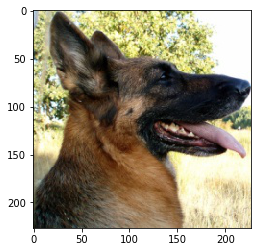

In [30]:
original_image = x_r[99]
original_image = scaler.inverse_transform(original_image)
img = np.reshape(original_image, (227,227,3))
img = Image.fromarray(img.astype('uint8'))
plt.imshow(img)

#### 2.1.2 First 60 principal components

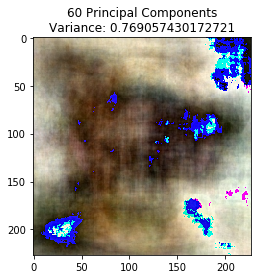

In [33]:
X_R_60, variance60 = getPCResults(copy.copy(X_t), copy.copy(my_pca), 0, 60)
img_60 = getReprojectedImage(X_R_60, scaler)
plotImage(img_60, variance60, 60)

As we can see, keeping 60 principal components results in an variance explanation equal to ~77%. The dog's shape is maintained, even with no much of details definition.

#### 2.1.3 First 6 principal components

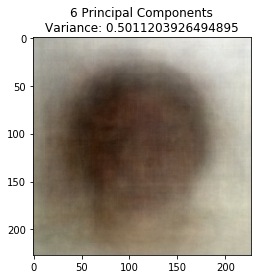

In [13]:
X_R_6, variance6 = getPCResults(copy.copy(X_t), copy.copy(my_pca), 0, 6)
img_6 = getReprojectedImage(X_R_6, scaler)
plotImage(img_6, variance6, 6)

#### 2.1.4 First 2 principal components

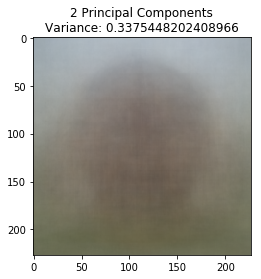

In [13]:
X_R_2, variance2 = getPCResults(copy.copy(X_t), copy.copy(my_pca), 0, 2)
img_2 = getReprojectedImage(X_R_2, scaler)
plotImage(img_2, variance2, 2)

Both this image and the previous one prove how keeping few principal components results in a non defined reprojection. 




#### 2.1.5 Last 6 principal components

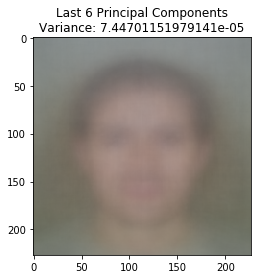

In [15]:
X_R_l6, variancel6 = getPCResults(copy.copy(X_t), copy.copy(my_pca), 1081, 1087)
img_l6 = getReprojectedImage(X_R_l6, scaler)
plotImage(img_l6, variancel6, 'Last 6')

Our original image is a picture of dog, but reprojecting it by using the last six components results in an image that seems a person. This could happen because the majority of images in the dataset represent people, so less important components derive from linear combinations of people images patterns.

### 2.2 Variance explained

Each plotted image has a label indicating the variance related to it. It shows how much of the original information has been keeped to plot the reprojected image.
A question to ask could be: how much explained variance is necessary to represented pretty well the compressed image?
Or, what value of explained variance could make me satisfied when I use this method for my analysis?
Well, answering to this question isn't easy, because there isn't a true value. The only way to find an answer is to set a value (a threshold) that separates "good values" and "not good values". Let's use the rule of thumb of 85%. So, in this analysis I consider good the number of principal components if they can explain more than 85% of variance in data. The answer of the previous question is that ~200 principal components might be enough according to the graph below, that shows how the variance varies when the number of principal components grows.

In [16]:
# Plots the variance spline function related to principal components
def plotSplineFunction(array):
    x_new = np.linspace(0, array.size, array.size)
    y = array
    plt.grid(True)
    plt.plot (x_new, y)
    plt.scatter (x_new, y)

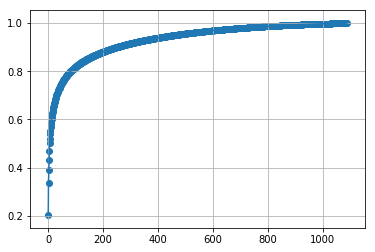

In [17]:
plotSplineFunction(my_pca.explained_variance_ratio_.cumsum())

### 2.3 Scatter plot visualization

In this section I plot the observation points according to new axes, i.e. the eigenvectors computed from the original matrix.

In [18]:
# Plots a scatter diagram to visualize principal components
def plotScatter(matrix, components_details, saving_name, index1, index2):
    dogIndex = numbers[0]-1
    guitarIndex = numbers[0]+numbers[1]-1
    houseIndex = numbers[0]+numbers[1]+numbers[2]-1
    personIndex = numbers[0]+numbers[1]+numbers[2]+numbers[3]-1

    colors=["red", "green", "dodgerblue", "yellow"]
    fig = plt.figure()
    a = fig.add_subplot(1, 1, 1)
    d = plt.scatter(matrix[0:dogIndex,index1], matrix[0:dogIndex,index2], marker='o', color=colors[0])
    g = plt.scatter(matrix[dogIndex+1:guitarIndex,index1], matrix[dogIndex+1:guitarIndex,index2], marker='o', color=colors[1])
    h = plt.scatter(matrix[guitarIndex+1:houseIndex,index1], matrix[guitarIndex+1:houseIndex,index2], marker='o', color=colors[2])
    p = plt.scatter(matrix[houseIndex+1:personIndex,index1], matrix[houseIndex+1:personIndex,index2], marker='o', color=colors[3])

    plt.legend((d,g,h,p),
               ('Dog', 'Guitar', 'House', 'Person'),
               loc='lower right',
               ncol=2,
               fontsize=8)
    plt.grid(True)
    a.set_title("Scatter plot of " + components_details + " principal components")
    plt.show()

#### 2.3.1 First and second principal components

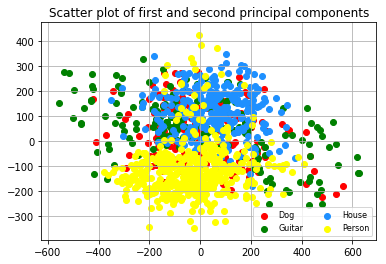

In [19]:
plotScatter(X_t, "first and second", "scatter_1_2", 0, 1)

What the plot shows is that the classes <b>person</b> and <b>house</b> are the more representative when first two principal components are taken and used as new axes for all data. However no one of these two classes better explain the variance, they stay above and below the axes of principal component axis and to left and right with respect to second component axis.

#### 2.3.2 Third and fourth principal components

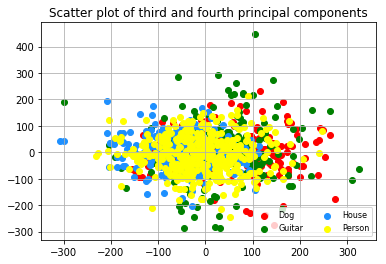

In [20]:
plotScatter(X_t, "third and fourth", "scatter_3_4", 2, 3)

Instead, this plot show the tendency of class </b>person</b> in better explaining the variance. As we can see just few points are far from axes while the majority of them stay close the axes. Observations of other classes are more far (more outliers). This is first sight on tendency of PCA to choose pattern related to the person class when the components are less important.

#### 2.3.3 Tenth and eleventh principal components

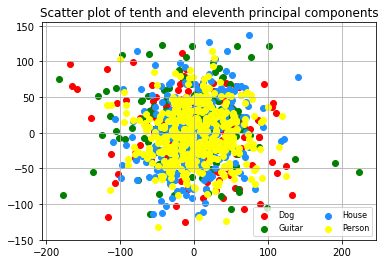

In [21]:
plotScatter(X_t, "tenth and eleventh", "scatter_10_11", 9, 10)

As exptected, choosing the tenth and eleventh principal components the class that better explain the variance is, more than previous time, the <b>person</b> one. This means that reprojecting images by using components no much important brings see a figure of person, even if our original image shows another subject. This thing is confirmed by the plots of reprojected images in the previous paragraph.

## 3 Classification

The last thing to do in this analysis is using a well known classification tecnique to classify data, both original images and images reprojected on such a couple of principal components. Then I show the decision boundaries used by this algorithm to classify data.
To do this job I need a training set (to train the model) and a testing set (a dataset of images without labels that model has to assign according to training data). In reality it's tricky to have a testing set and so some tecniques has been invented to solve this problem. One of that is called <b>cross-validation</b> and consists in splitting labelled data in training set and testing set, in order to train the model with the first and test its accuracy with the second one.

### 3.1 Naive Bayes Classifier
Naive Bayes is a kind of classifier which uses the Bayes Theorem. It predicts membership probabilities for each class such as the probability that given record or data point belongs to a particular class.  The class with the highest probability is considered as the most likely class. This is also known as <b>Maximum A Posteriori (MAP)</b>.

In [35]:
Math(r'\hat{y} = \arg\max_y P(y) \prod_{i=1}^{n} P(x_i \mid y)')

<IPython.core.display.Math object>

### 3.2 Prediction and decision boundaries

In [18]:
def classification(X_train, X_test, y_train, y_test):    
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    GaussianNB(priors=None, var_smoothing=1e-09)
    print("Accuracy: {}".format(clf.score(X_test, y_test)))
    return clf

In [56]:
def plot_boundaries(X, y, clf, index1, index2, xlabel, ylabel):
    x_min, x_max = X[:, index1].min() - 1, X[:, index1].max() + 1
    y_min, y_max = X[:, index2].min() - 1, X[:, index2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap="brg", alpha=0.4)
    plt.scatter(X[:,index1], X[:,index2], c=y, marker='o', edgecolor='k', cmap="brg")
    plt.title("Decision boundaries of Naive Bayes Classifier")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In next code blocks it's possible to see how well or not the classifier works when I provide data in the original shape, reprojected just only on first two principal components and then on third and fourth principal components. What I expect is that the accuracy is higher when components are more important. And so it is.

In [22]:
# Classification with the original dataset
X_train, X_test, y_train, y_test = train_test_split(x_r, copy.copy(y), test_size=0.4, random_state=0)
classifier_original = classification(X_train, X_test, y_train, y_test) 

Accuracy: 0.7218390804597701


Accuracy: 0.6045977011494252


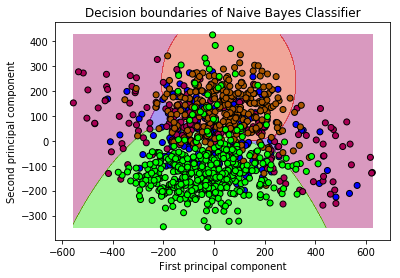

In [57]:
# Classification with first and second principal components
X_train_1_2, X_test_1_2, y_train_1_2, y_test_1_2 = train_test_split(copy.copy(X_t)[:,0:2], copy.copy(y), test_size=0.4, random_state=0)
classifier_1_2 = classification(X_train_1_2, X_test_1_2, y_train_1_2, y_test_1_2)
plot_boundaries(copy.copy(X_t), copy.copy(y), classifier_1_2, 0, 1, "First principal component", "Second principal component")

Accuracy: 0.4436781609195402


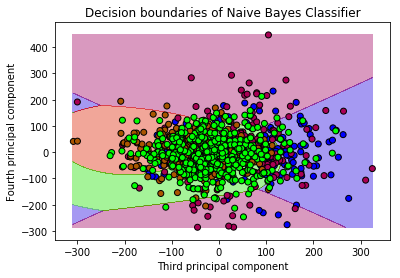

In [58]:
# Classification with third and fourth principal components
X_train_3_4, X_test_3_4, y_train_3_4, y_test_3_4 = train_test_split(copy.copy(X_t)[:,2:4], copy.copy(y), test_size=0.4, random_state=0)
classifier_3_4 = classification(X_train_3_4, X_test_3_4, y_train_3_4, y_test_3_4) 
plot_boundaries(copy.copy(X_t), copy.copy(y), classifier_3_4, 2, 3, "Third principal component", "Fourth principal component")